In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(77)

In [3]:
df = pd.read_csv('player_shot.csv')

In [4]:
df.head()

,name,preferred_foot,situation,shotType,shotResult,xGoal
0,Memphis Depay,Right,SetPiece,RightFoot,BlockedShot,0.064342
1,Memphis Depay,Right,OpenPlay,RightFoot,BlockedShot,0.035742
2,Memphis Depay,Right,OpenPlay,LeftFoot,MissedShots,0.021225
3,Ashley Young,Right,OpenPlay,RightFoot,SavedShot,0.103004
4,Wayne Rooney,Right,OpenPlay,RightFoot,MissedShots,0.106513


In [5]:
df.isna().sum()

name              0
preferred_foot    0
situation         0
shotType          0
shotResult        0
xGoal             0
dtype: int64

In [6]:
df.shape

(241960, 6)

In [7]:
df['shotType'].value_counts()

shotType
RightFoot        123680
LeftFoot          76798
Head              40520
OtherBodyPart       962
Name: count, dtype: int64

In [8]:
df['situation'].value_counts()

situation
OpenPlay          177282
FromCorner         35163
SetPiece           15748
DirectFreekick     10795
Penalty             2972
Name: count, dtype: int64

In [9]:
df['shotResult'].value_counts()

shotResult
MissedShots    94546
BlockedShot    59818
SavedShot      56543
Goal           25647
ShotOnPost      4649
OwnGoal          757
Name: count, dtype: int64

In [10]:
df = df[df['shotType'].isin(['RightFoot', 'LeftFoot'])]
df = df[df['situation'] == 'OpenPlay']
df = df[~df['shotResult'].isin(['OwnGoal', 'ShotOnPost'])]

In [11]:
df['goal'] = df['shotResult'].apply(lambda x: 1 if x == 'Goal' else 0)
df['efficiency'] = df['goal'] - df['xGoal']

In [12]:
player_efficiency = df.groupby(['name', 'preferred_foot']).agg(
    total_shots=('goal', 'count'),
    total_goals=('goal', 'sum'),
    total_xg=('xGoal', 'sum'),
    total_efficiency=('efficiency', 'sum'),
    avg_efficiency=('efficiency', 'mean')
).reset_index()

In [13]:
player_efficiency.shape

(3234, 7)

In [14]:
player_efficiency.sample(10)

,name,preferred_foot,total_shots,total_goals,total_xg,total_efficiency,avg_efficiency
1771,Levan Mchedlidze,Left,48,6,4.697567,1.302433,0.027134
894,Ezequiel Schelotto,Right,29,0,1.219024,-1.219024,-0.042035
190,Amos Youga,Right,14,0,0.714976,-0.714976,-0.051070
390,Benjamin Stambouli,Right,13,0,0.354402,-0.354402,-0.027262
2393,Omar Colley,Left,3,0,0.431316,-0.431316,-0.143772
1019,Fran Rico,Left,26,3,1.543437,1.456563,0.056022
556,Christoph Moritz,Right,2,0,0.070020,-0.070020,-0.035010
3157,Yann Gboho,Right,12,1,0.975575,0.024425,0.002035
1330,James Wilson,Left,7,1,1.025449,-0.025449,-0.003636
1282,Iván Ramis,Right,3,0,0.042151,-0.042151,-0.014050


In [15]:
player_eff_clean = player_efficiency.copy()

In [16]:
player_eff_clean = player_eff_clean[player_eff_clean['total_shots'] >= 10]

In [17]:
player_eff_clean.head()

,name,preferred_foot,total_shots,total_goals,total_xg,total_efficiency,avg_efficiency
0,Aaron Cresswell,Left,70,5,3.363555,1.636445,0.023378
1,Aaron Hunt,Left,50,6,4.485602,1.514398,0.030288
2,Aaron Lennon,Right,39,8,4.842588,3.157412,0.080959
3,Aaron Leya Iseka,Right,53,7,7.696844,-0.696844,-0.013148
4,Aaron Mooy,Right,76,6,4.942427,1.057573,0.013915


In [18]:
player_eff_clean.shape

(2073, 7)

In [19]:
max_xg_player = player_eff_clean.loc[player_eff_clean['total_xg'].idxmax()]
print(max_xg_player)

name                Robert Lewandowski
preferred_foot                   Right
total_shots                        574
total_goals                        132
total_xg                    123.478104
total_efficiency              8.521896
avg_efficiency                0.014847
Name: 2612, dtype: object


In [20]:
left_foot  = player_eff_clean[player_eff_clean['preferred_foot']=='Left']['avg_efficiency']
right_foot = player_eff_clean[player_eff_clean['preferred_foot']=='Right']['avg_efficiency']

left_mean  = left_foot.mean()
right_mean = right_foot.mean()

print(f"Left-footed mean efficiency: {left_mean:.4f}")
print(f"Right-footed mean efficiency: {right_mean:.4f}")
print(f"Difference (Left - Right): {left_mean - right_mean:.4f}")


Left-footed mean efficiency: -0.0008
Right-footed mean efficiency: -0.0041
Difference (Left - Right): 0.0033


In [21]:
left_vals  = left_foot.values
right_vals = right_foot.values

obs_diff = left_vals.mean() - right_vals.mean()
print(f"Observed difference: {obs_diff:.4f}")

Observed difference: 0.0033


In [22]:
combined = np.concatenate([left_vals, right_vals])

In [24]:
n_perm = 10000
perm_diffs = np.zeros(n_perm)


for i in range(n_perm):
    shuffled = np.random.permutation(combined)   
    sample_group1 = shuffled[:len(left_vals)]
    sample_group2 = shuffled[len(left_vals):]
    perm_diffs[i] = np.mean(sample_group1) - np.mean(sample_group2)

In [25]:
p_value = np.mean(perm_diffs >= obs_diff)
print(f"P-value: {p_value:.4f}")

P-value: 0.0668


In [26]:
n_boot = 10000
boot_diffs = np.zeros(n_boot)

np.random.seed(77)
for i in range(n_boot):
    left_star  = np.random.choice(left_vals,  size=len(left_vals),  replace=True)
    right_star = np.random.choice(right_vals, size=len(right_vals), replace=True)
    boot_diffs[i] = left_star.mean() - right_star.mean()

In [27]:
ci_low  = np.percentile(boot_diffs, 2.5)
ci_high = np.percentile(boot_diffs, 97.5)

print(f"95% Bootstrap CI: ({ci_low:.4f}, {ci_high:.4f})")

95% Bootstrap CI: (-0.0009, 0.0076)


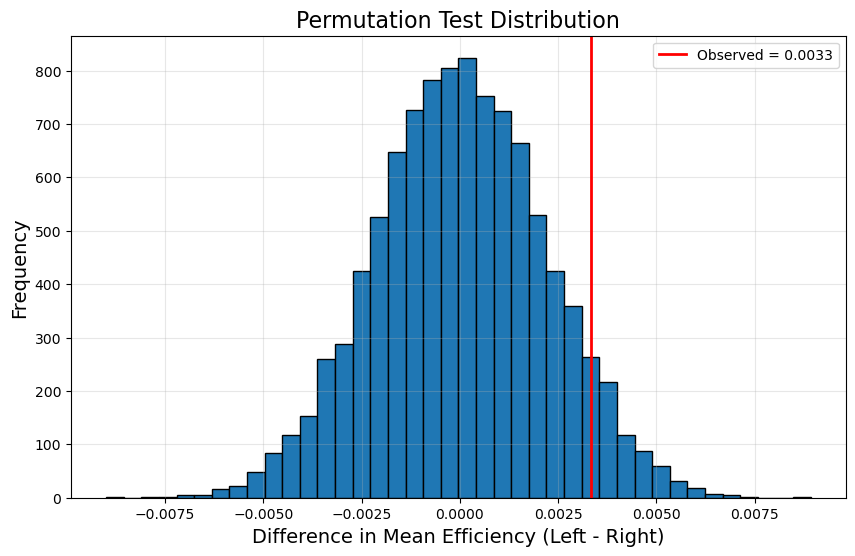

In [28]:
plt.figure(figsize=(10,6))
plt.hist(perm_diffs, bins=40, edgecolor='black')
plt.axvline(obs_diff, color='red', linewidth=2, label=f"Observed = {obs_diff:.4f}")

plt.title("Permutation Test Distribution", fontsize=16)
plt.xlabel("Difference in Mean Efficiency (Left - Right)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.show()

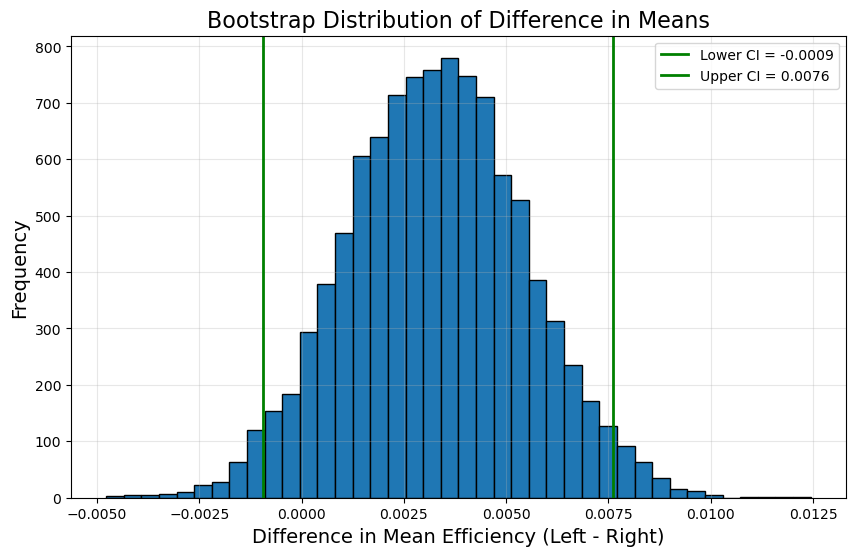

In [29]:
plt.figure(figsize=(10,6))
plt.hist(boot_diffs, bins=40, edgecolor='black')
plt.axvline(ci_low,  color='green', linewidth=2, label=f"Lower CI = {ci_low:.4f}")
plt.axvline(ci_high, color='green', linewidth=2, label=f"Upper CI = {ci_high:.4f}")

plt.title("Bootstrap Distribution of Difference in Means", fontsize=16)
plt.xlabel("Difference in Mean Efficiency (Left - Right)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.show()
